<a href="https://colab.research.google.com/github/RajaBabu15/PINNs/blob/main/PINNs_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def exact_solution(d,w0,t):
  "Defines the analytical solution to the under-damped harmonic oscillator problem."
  assert d<w0
  w=np.sqrt(w0**2-d**2) # omega^2=omega_not^2-d^2
  phi=np.arctan(-d/w)
  A=1/(2*np.cos(phi))
  cos=torch.cos(phi+w*t)
  exp=torch.exp(-d*t)
  u= A*2*cos*exp
  return u

In [ ]:
class FCN(nn.Module):
  "Defines a fully-connected network in PyTorch."
  def __init__(self,N_INPUT,N_OUTPUT,N_HIDDEN,N_LAYERS):
    super().__init__()
    activation=nn.Tanh
    self.fcs=nn.Sequential(*[
        nn.Linear(N_INPUT,N_HIDDEN),
        activation()
        ])
    self.fch=nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(N_HIDDEN,N_HIDDEN),
            activation()
        ]) for _ in range(N_LAYERS-1)
      ])
    self.fce=nn.Linear(N_HIDDEN,N_OUTPUT)

  def forward(self,x):
    x=self.fcs(x)
    x=self.fch(x)
    x=self.fce(x)
    return x

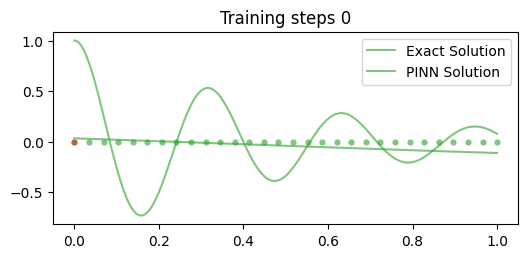

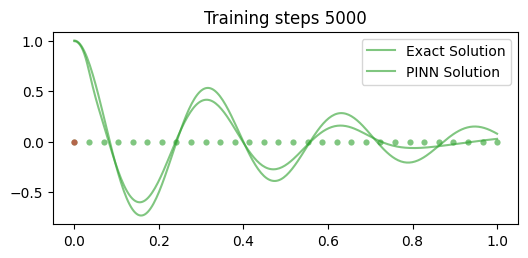

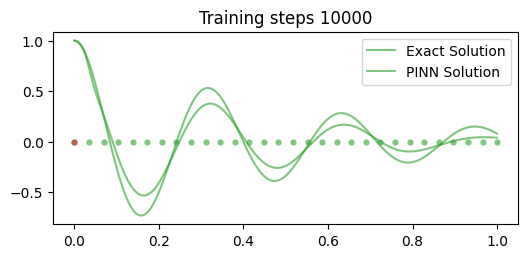

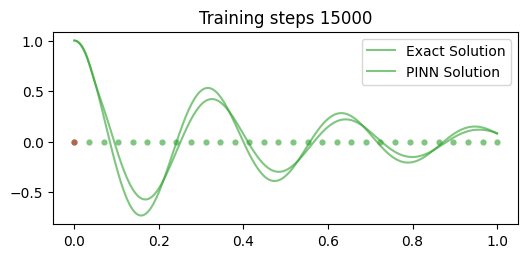

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the neural network (fully connected network, FCN)
class FCN(nn.Module):
    def __init__(self, in_features, out_features, hidden_units, hidden_layers):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_features, hidden_units), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_units, out_features))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Set the manual seed for reproducibility
torch.manual_seed(123)

# Define the neural network and move it to the GPU
pinn = FCN(1, 1, 50, 3).to(device)

# Add colocation points for physics loss and move them to the GPU
t_boundary = torch.tensor(0., requires_grad=True).view(-1, 1).to(device)
t_physics = torch.linspace(0, 1, 30, requires_grad=True).view(-1, 1).to(device)

# Parameters
d, w0 = 2, 20
mu, k = 2 * d, w0 ** 2
t_test = torch.linspace(0, 1, 300).view(-1, 1).to(device)
u_exact = exact_solution(d, w0, t_test).to(device)
optimizer = optim.Adam(pinn.parameters(), lr=1e-3)

# Training loop
for i in range(15001):
    optimizer.zero_grad()

    lambda1, lambda2 = 1e-1, 1e-4

    # Compute Boundary Loss
    u_boundary = pinn(t_boundary)
    loss1 = torch.squeeze((u_boundary - 1) ** 2)
    du_boundary = torch.autograd.grad(u_boundary, t_boundary, torch.ones_like(u_boundary), create_graph=True)[0]
    loss2 = torch.squeeze((du_boundary - 0) ** 2)

    # Compute Physics Loss
    u_physics = pinn(t_physics)
    du_physics = torch.autograd.grad(u_physics, t_physics, torch.ones_like(u_physics), create_graph=True)[0]
    du2_physics = torch.autograd.grad(du_physics, t_physics, torch.ones_like(du_physics), create_graph=True)[0]
    loss3 = torch.mean((du2_physics + mu * du_physics + k * u_physics) ** 2)

    # Backpropagate joint loss, take optimizer step
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3
    loss.backward()
    optimizer.step()

    # Print the loss every 500 iterations
    if i % 5000 == 0:
        u_test = pinn(t_test).detach().cpu()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_physics.detach().cpu()[:, 0], torch.zeros_like(t_physics).cpu()[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach().cpu()[:, 0], torch.zeros_like(t_boundary).cpu()[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test.cpu()[:, 0], u_exact.cpu()[:, 0], label="Exact Solution", color="tab:green", alpha=0.6)
        plt.plot(t_test.cpu()[:, 0], u_test[:, 0], label="PINN Solution", color="tab:blue", alpha=0.6)
        plt.title(f"Training steps {i}")
        plt.legend(loc="best")
        plt.show()
